# Uncovering Insights on Seatle Airbnb's

## Problem Statement
The purpose of this analysis is to uncover the underliying do and don't when listing houses up for booking on the airbnb website. This analysis should be used to aid hosts in deciding how to list their accomidation. to do this we looked to answer 3 questions (shown below) related to their listings, that would aid in attracting more guests.

- **How to price listings?**
- **How does the price impact the reviews?**
- **Which amenities are important?**

## Set Up
We will be using 3 data sets. Calendar which contains availabilty of listings including price on each day through a 13 month period. Listings which have all attribute on the listings on the website. Lastly the Reviews of each reviwer and the listing being reviews.

To uncover this we need a way to manipulate dataframes, model to see anyrelationships etc, and lastly a way to manipulate texts from the reviews. the libraries used for this are highlighted below.

### Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
from sklearn.metrics import mean_absolute_error
%matplotlib inline
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
sia= SentimentIntensityAnalyzer()


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rethabilepule/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rethabilepule/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rethabilepule/nltk_data...


## Data Read in

In [3]:
# Data Read in
Calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews  = pd.read_csv('reviews.csv')


**Calendar Dataset**

In [4]:
Calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


**Listings Dataset**

In [5]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


**Reviews Dataset**

In [6]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


#

## Question 1 - How to price listings?

To view listing's price we can use the Calendar dataframe which will allow us to see how listings are prices accros the 13 month period and see the trend of the prices.
First by looking at the dataframe we can see that we need a way to format the price and date column so that we can minipulate and use them for our analysis. 

In [7]:
Calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


we first need to transform the date column so that we can use it as a date data type, as well as drop the dollar sign in the price such that we can uncover averages etc.

In [8]:
# Calandar Transform
Calendar['date'] = pd.to_datetime(Calendar['date'], format = '%Y-%m-%d') #date
#Remove Dollar sign
Calendar['price'] = Calendar['price'].replace('[\$,]', '', regex=True).astype(float)

Calendar.head()
 

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


Here we now check if the price column has been tranformed and ensure we don't just have the same values (NAs and 85.0)

In [9]:
#Check Price column
Calendar['price'].unique()



array([  85.,   nan,  125.,  154.,  164.,  165.,  150.,  145.,  144.,
        148.,  155.,  149.,  156.,  166.,  152.,  147.,  146.,  151.,
        158.,  168.,  169.,  192.,  175.,  162.,  171.,  173.,  153.,
        177.,  183.,  181.,  170.,  179.,  167.,  184.,  186.,  172.,
        180.,  190.,  178.,  196.,  197.,  202.,  198.,  205.,  214.,
        218.,  211.,  193.,  204.,  189.,  187.,  194.,  185.,  206.,
        191.,  207.,  208.,  188.,  200.,  209.,  210.,  195.,  201.,
        199.,  203.,  182.,  163.,  159.,  157.,  142.,  136.,  134.,
        137.,  143.,  135.,  141.,  130.,  138.,  133.,  129.,  127.,
        126.,  131.,  132.,  220.,  222.,  223.,  232.,  217.,  229.,
        294.,  358.,  439.,  400.,  975.,  750.,  500.,  650.,  675.,
       1250., 1450., 1650.,  100.,  600.,  450.,  475.,  120.,  140.,
         80.,   42.,   49.,   60.,   48.,   47.,   52.,   51.,   50.,
         53.,   61.,   54.,   62.,   55.,   90.,  139.,   95.,   69.,
         71.,   74.,

The next step was to understand the nature of the data, by checking how the data looked when group by the availability. seeing that most listing were fairly available with around 70 percent of the time listing are available. We also noticed that when the listing was not available then there was no price. Which meant moving foward we would have to remove rows when the listing was not available.

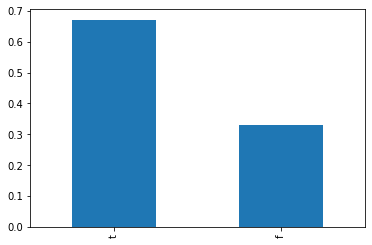

In [10]:
#check availability %
vals = Calendar.available.value_counts()
(vals/Calendar.shape[0]).plot(kind="bar");

In [11]:
vals

t    934542
f    459028
Name: available, dtype: int64

In [12]:
## See pricing over time for 3 random listings

#first sample 3 listings 

ids = Calendar.listing_id.unique()


We then took a sample of one of the listing to understand how its pricing changed throughout the year.

In [13]:
random.seed(40)
Ids = list(random.choices(ids, k = 1)) 
Ids

[8784239]

In [14]:
#then Check their price remove when not available

df_sample = Calendar.loc[Calendar['listing_id'].isin(Ids)]
df_sample = df_sample.loc[df_sample['available'] == 't']
df_sample

,listing_id,date,available,price
638750,8784239,2016-01-04,t,90.0
638751,8784239,2016-01-05,t,90.0
638752,8784239,2016-01-06,t,90.0
638753,8784239,2016-01-07,t,90.0
638754,8784239,2016-01-08,t,100.0
...,...,...,...,...
639110,8784239,2016-12-29,t,90.0
639111,8784239,2016-12-30,t,100.0
639112,8784239,2016-12-31,t,100.0
639113,8784239,2017-01-01,t,90.0


In [15]:
df_sample

,listing_id,date,available,price
638750,8784239,2016-01-04,t,90.0
638751,8784239,2016-01-05,t,90.0
638752,8784239,2016-01-06,t,90.0
638753,8784239,2016-01-07,t,90.0
638754,8784239,2016-01-08,t,100.0
...,...,...,...,...
639110,8784239,2016-12-29,t,90.0
639111,8784239,2016-12-30,t,100.0
639112,8784239,2016-12-31,t,100.0
639113,8784239,2017-01-01,t,90.0


In [16]:
df_sample_2 = df_sample.drop('available', axis = 1)

In [17]:
df_sample_2

,listing_id,date,price
638750,8784239,2016-01-04,90.0
638751,8784239,2016-01-05,90.0
638752,8784239,2016-01-06,90.0
638753,8784239,2016-01-07,90.0
638754,8784239,2016-01-08,100.0
...,...,...,...
639110,8784239,2016-12-29,90.0
639111,8784239,2016-12-30,100.0
639112,8784239,2016-12-31,100.0
639113,8784239,2017-01-01,90.0


In [18]:
df_sample_2['listing_id'] = df_sample_2['listing_id'].astype(str)

On the graph below we see that the price flactuates quite frequently with the diffrence between the highest and lowest was $10. so from this we might be better using averages of all listing per month as it would get confusing if we did per day.

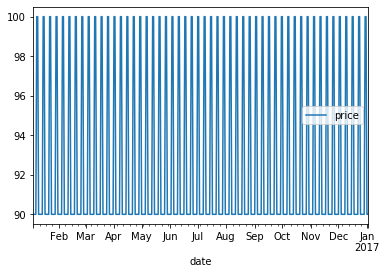

In [19]:
df_sample_2.plot(x = 'date', y = 'price' ); ## Prices don't flactuate a lot through out the year

Check the distribution of the prices. Can see that most are priced around the $75-$160 price point.

In [20]:
Calendar.describe()

,listing_id,price
count,1.393570e+06,934542.000000
mean,5.550111e+06,137.944859
std,2.962274e+06,105.062870
min,3.335000e+03,10.000000
25%,3.258213e+06,75.000000
50%,6.118244e+06,109.000000
75%,8.035212e+06,160.000000
max,1.034016e+07,1650.000000


Next we explored which month would be the most expensive, so we used our previous findings and aggregated the average price of the lsitings to see whichh was the most expensive month.

In [22]:
## lets see which month is busy (where available = F) but first we need to see if when available is false is it occupied
df_sample = Calendar.loc[Calendar['available'] == 't']

In [23]:
df_sample

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
9,241032,2016-01-13,t,85.0
10,241032,2016-01-14,t,85.0
14,241032,2016-01-18,t,85.0
...,...,...,...,...
1393207,10208623,2016-01-06,t,87.0
1393208,10208623,2016-01-07,t,87.0
1393211,10208623,2016-01-10,t,87.0
1393212,10208623,2016-01-11,t,87.0


Aggregate price(mean) over the months

In [24]:
sample = df_sample.groupby(['listing_id', df_sample['date'].dt.to_period("M")]).agg({'price':'mean'}).reset_index()

In [25]:
# See which month has high price
sample_2 = sample.groupby(['date']).agg({'price':'mean'}).reset_index()
sample_2


,date,price
0,2016-01,118.925929
1,2016-02,123.809194
2,2016-03,128.477274
3,2016-04,133.058710
4,2016-05,140.706452
5,2016-06,149.974092
6,2016-07,154.369813
7,2016-08,151.910558
8,2016-09,143.995804
9,2016-10,136.940014


We see that the Month of July had the highest average price.

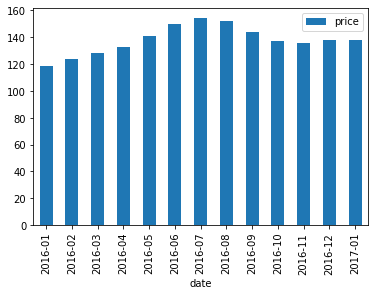

In [26]:
sample_2.plot(x = 'date', y='price', kind = 'bar');

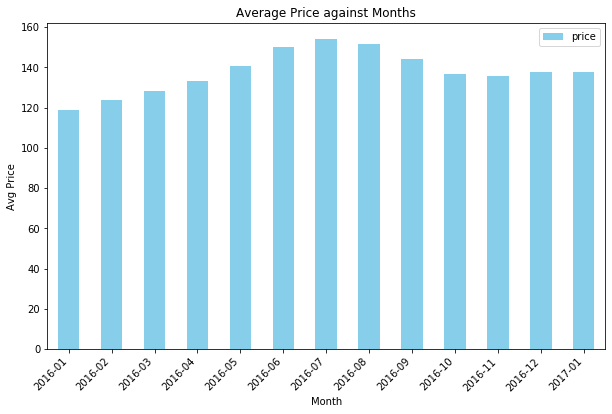

In [27]:
#plot Average prices across the months
sample_2.plot(x='date', y='price', kind='bar', color='skyblue', figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Avg Price')
plt.title('Average Price against Months')
plt.xticks(rotation=45, ha='right')
plt.show()

In [28]:
df_sample

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
9,241032,2016-01-13,t,85.0
10,241032,2016-01-14,t,85.0
14,241032,2016-01-18,t,85.0
...,...,...,...,...
1393207,10208623,2016-01-06,t,87.0
1393208,10208623,2016-01-07,t,87.0
1393211,10208623,2016-01-10,t,87.0
1393212,10208623,2016-01-11,t,87.0


Here we uncover how much the price changes accross the year

In [29]:
## Check which listing has a high month price differential

sample_diff = sample.groupby('listing_id')['price'].agg(lambda x: x.max() - x.min()).reset_index()
sample_diff.rename(columns={'price': 'price_difference'}, inplace=True)
sample_diff


,listing_id,price_difference
0,3335,0.000000
1,4291,0.000000
2,5682,12.000000
3,6606,3.333333
4,7369,0.000000
...,...,...
3718,10331249,0.000000
3719,10332096,0.000000
3720,10334184,0.000000
3721,10339145,80.000000


We see that some price changes are has high as $1050 quite high compared to the minimum and average.

In [30]:
sample_diff.sort_values(by = 'price_difference', ascending = False)

,listing_id,price_difference
961,3308979,1050.000000
2570,7678064,562.000000
2602,7733192,450.000000
1550,5022572,445.833333
1561,5048597,440.900000
...,...,...
1788,5902452,0.000000
1784,5882923,0.000000
1782,5873892,0.000000
1775,5848330,0.000000


In [31]:
#create a little DF
avg_change = sample_diff['price_difference'].mean()
min_change = sample_diff['price_difference'].min()
max_change = sample_diff['price_difference'].max()
DF_Sum = pd.DataFrame({
    'Average': [avg_change],
    'Min': [min_change],
    'Max': [max_change]
})
DF_Sum

,Average,Min,Max
0,30.532276,0.0,1050.0


Plot the diffrences

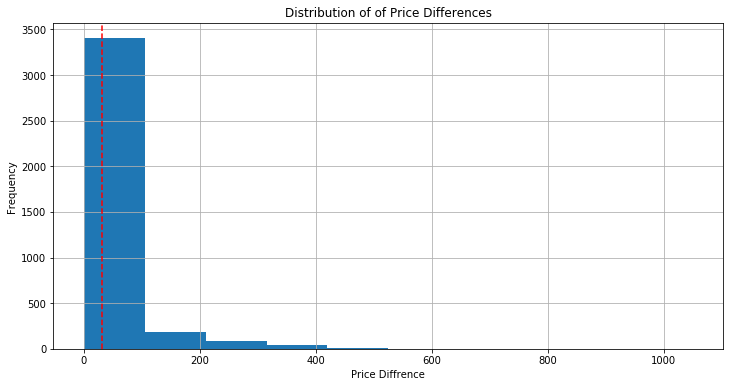

In [32]:
hist = sample_diff.hist(column='price_difference', figsize=(12, 6))
plt.axvline(x=sample_diff['price_difference'].mean(), color='red', linestyle='--', label='Average') #add the average lin in red
plt.title('Distribution of of Price Differences')
plt.xlabel('Price Diffrence')
plt.ylabel('Frequency')


plt.show()

Couriosty killed the cat, checking the listing with the highest price difference

In [33]:
#Calendar.loc[Calendar['available'] == 't']
listings.loc[listings['id'] == 3308979]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


## Question 2 - How do pricings affect reviews?

In [34]:
## See the reviews vs price
listings.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


Check which listings are missing reviews, then joining with calendar to get the average pricing.

In [35]:
#check which listings don't have reviews per month
listings['reviews_per_month'].isna().sum()/listings.shape[0]

0.1642221058145626

In [37]:
Calendar.groupby('listing_id').agg({'price':'mean'}).reset_index()

,listing_id,price
0,3335,120.000000
1,4291,82.000000
2,5682,53.944984
3,6606,92.849315
4,7369,85.000000
...,...,...
3813,10332096,40.000000
3814,10334184,120.000000
3815,10339144,NaN
3816,10339145,237.904110


In [38]:
#lets join listings with price because this port we plan on doing averege reviews per price
#first lets get average price for listings
calendar_avg = Calendar.groupby('listing_id').agg({'price':'mean'}).reset_index()
calendar_avg.rename(columns={'listing_id': 'id', 'price':'avg_price'}, inplace = True)
calendar_avg

,id,avg_price
0,3335,120.000000
1,4291,82.000000
2,5682,53.944984
3,6606,92.849315
4,7369,85.000000
...,...,...
3813,10332096,40.000000
3814,10334184,120.000000
3815,10339144,NaN
3816,10339145,237.904110


In [39]:
#join
listings_calendar = pd.merge(listings, calendar_avg, on = 'id', how = 'left')
listings_calendar

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,avg_price
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,85.000000
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,f,NaN,WASHINGTON,f,strict,t,t,6,1.48,170.931271
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,f,NaN,WASHINGTON,f,strict,f,f,2,1.15,1301.818182
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN,100.000000
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,f,NaN,WASHINGTON,f,strict,f,f,1,0.89,462.739726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,https://www.airbnb.com/rooms/8101950,20160104002432,2016-01-04,3BR Mountain View House in Seattle,Our 3BR/2BA house boasts incredible views of t...,"Our 3BR/2BA house bright, stylish, and wheelch...",Our 3BR/2BA house boasts incredible views of t...,none,We're located near lots of family fun. Woodlan...,...,f,NaN,WASHINGTON,f,strict,f,f,8,0.30,359.000000
3814,8902327,https://www.airbnb.com/rooms/8902327,20160104002432,2016-01-04,Portage Bay View!-One Bedroom Apt,800 square foot 1 bedroom basement apartment w...,This space has a great view of Portage Bay wit...,800 square foot 1 bedroom basement apartment w...,none,The neighborhood is a quiet oasis that is clos...,...,f,NaN,WASHINGTON,f,moderate,f,f,1,2.00,100.201465
3815,10267360,https://www.airbnb.com/rooms/10267360,20160104002432,2016-01-04,Private apartment view of Lake WA,"Very comfortable lower unit. Quiet, charming m...",NaN,"Very comfortable lower unit. Quiet, charming m...",none,NaN,...,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN,87.886364
3816,9604740,https://www.airbnb.com/rooms/9604740,20160104002432,2016-01-04,Amazing View with Modern Comfort!,Cozy studio condo in the heart on Madison Park...,Fully furnished unit to accommodate most needs...,Cozy studio condo in the heart on Madison Park...,none,Madison Park offers a peaceful slow pace upsca...,...,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN,99.000000


In [40]:
#check the columns we have
listings_calendar.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

After joining, assesing the nature of the data and doing clean ups. the goal is to achieve the review scores and the prices of the listings.

In [41]:
# Check review scores vs price
scores = listings_calendar[['id', 'name', 'description','review_scores_rating', 'reviews_per_month','avg_price']]
scores.head()

,id,name,description,review_scores_rating,reviews_per_month,avg_price
0,241032,Stylish Queen Anne Apartment,Make your self at home in this charming one-be...,95.0,4.07,85.000000
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,96.0,1.48,170.931271
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,97.0,1.15,1301.818182
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,NaN,100.000000
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,92.0,0.89,462.739726


In [42]:
#check for duplicates
scores['id'].nunique()/scores.shape[0] #no duplicates

1.0

In [43]:
# Remove listings without price and rating
#first check percentage we would be losing
(scores[['review_scores_rating', 'avg_price']].isna().any(axis=1).sum() * 100)/scores.shape[0]

18.779465688842325

In [44]:
#then remove rows
scores_clean = scores.dropna(subset=['review_scores_rating', 'avg_price'])


In [45]:
#check
(scores_clean[['review_scores_rating', 'avg_price']].isna().any(axis=1).sum() * 100)/scores_clean.shape[0]

0.0

Once cleaned, check how the reviews look vs the average prices. We see that there is no relationship as the scores are mostly at the highend.

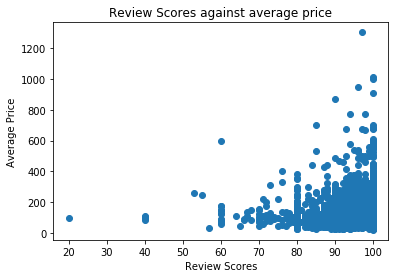

In [46]:
# check scatter of price against reviews
plt.scatter(x= scores_clean['review_scores_rating'], y = scores_clean['avg_price'])
plt.xlabel('Review Scores')
plt.ylabel('Average Price')
plt.title('Review Scores against average price')

plt.show()


In [47]:
#check correlation 
correlation = scores_clean['review_scores_rating'].corr(scores_clean['avg_price'])
correlation


0.06487541572111215

No correlation between scores and price.

In [48]:
scores_clean['avg_price'].mean()

135.3403530861848

Next is we group the scores into buckets which will allow us to see how each bucket is priced.

In [49]:
buckets = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
scores_clean['Review_bucket'] = pd.cut(scores_clean['review_scores_rating'], bins=buckets)
scores_clean.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,name,description,review_scores_rating,reviews_per_month,avg_price,Review_bucket
0,241032,Stylish Queen Anne Apartment,Make your self at home in this charming one-be...,95.0,4.07,85.000000,"(90, 100]"
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,96.0,1.48,170.931271,"(90, 100]"
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,97.0,1.15,1301.818182,"(90, 100]"
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,92.0,0.89,462.739726,"(90, 100]"
5,5956968,Private unit in a 1920s mansion,We're renting out a small private unit of one ...,95.0,2.45,125.629139,"(90, 100]"


In [50]:
#groupby('listing_id').agg({'price':'mean'}).reset_index()
review_per_price = scores_clean.groupby('Review_bucket')['avg_price'].mean().reset_index()

In [51]:
review_per_price

,Review_bucket,avg_price
0,"(0, 10]",NaN
1,"(10, 20]",95.614035
2,"(20, 30]",NaN
3,"(30, 40]",100.232955
4,"(40, 50]",NaN
5,"(50, 60]",162.383412
6,"(60, 70]",102.353590
7,"(70, 80]",126.429327
8,"(80, 90]",127.721505
9,"(90, 100]",137.053914


Here we see that the listings with average scores are priced the highest, meaning they could have been very expensive in comparison to what the guest got in return.

Text(0.5, 1.0, 'Average Price vs. Review Bucket')

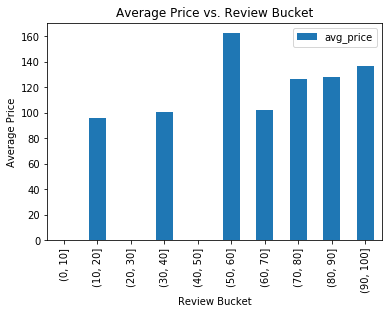

In [52]:
review_per_price.plot(x = 'Review_bucket', y = 'avg_price',  kind = 'bar');
plt.xlabel('Review Bucket')
plt.ylabel('Average Price')
plt.title('Average Price vs. Review Bucket') 

In [53]:
#So the highest price average got and average rating score, not not all highly priced bnbs have high review scores. also nice to see the counts
counts = pd.DataFrame(scores_clean['Review_bucket'].astype(str).value_counts().reset_index())
counts.columns = ['Review_bucket', 'Counts']
counts


,Review_bucket,Counts
0,"(90, 100]",2554
1,"(80, 90]",371
2,"(70, 80]",140
3,"(60, 70]",16
4,"(50, 60]",15
5,"(30, 40]",4
6,"(10, 20]",1


In [54]:
scores_clean.dtypes

id                         int64
name                      object
description               object
review_scores_rating     float64
reviews_per_month        float64
avg_price                float64
Review_bucket           category
dtype: object

Next see the distribution of each bucket.

<Figure size 7200x432 with 0 Axes>

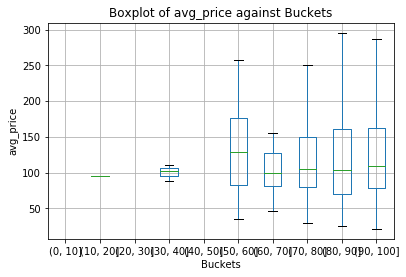

In [55]:
#lets create box plot
#the_90s = scores_clean[scores_clean['Review_bucket'] == pd.Interval(90, 100, closed='right')]
plt.figure(figsize=(100, 6))
scores_clean.boxplot(column = 'avg_price', by = 'Review_bucket', showfliers=False, vert=True);
plt.title(f'Boxplot of avg_price against Buckets')
plt.xlabel('Buckets')
plt.ylabel('avg_price')
plt.suptitle('')
plt.show()

We the dive deeper into the reviews, to do this we do sentiment analyis, which will assist in assesing the emotions of each review.

In [56]:
#now lets try to check the sentiment of reviews to check against the price
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


### Clean and feature engeenering

In [57]:
#steps
# 1. remove stop words
# 2. Tokenise the comments (try unigrams, then bigrams (for negating words))
# 3. get sentiments
# 4. adjust for negation
listings_calendar.head()


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,avg_price
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,85.000000
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,f,NaN,WASHINGTON,f,strict,t,t,6,1.48,170.931271
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,f,NaN,WASHINGTON,f,strict,f,f,2,1.15,1301.818182
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN,100.000000
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,f,NaN,WASHINGTON,f,strict,f,f,1,0.89,462.739726


In [58]:
#select nessesary columns
reviews_1 = reviews[['listing_id','id','comments']]
reviews_1.head()


,listing_id,id,comments
0,7202016,38917982,Cute and cozy place. Perfect location to every...
1,7202016,39087409,Kelly has a great room in a very central locat...
2,7202016,39820030,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,Close to Seattle Center and all it has to offe...
4,7202016,41986501,Kelly was a great host and very accommodating ...


In [59]:
#create function that tokenizes and removes stopwords/punctuation
def Tokenize (text, n = 2):
    ''' 
    input: text to each revies
    process: to seperate each word from the comment, while handling puntuations and stop word (don't give us much information)
    output: bigrams (word seperated with the next word split into 2 columns)
    
    '''
    text_no_pun = text.translate(str.maketrans("","", string.punctuation))#remove punctuation
    stop_words = set(stopwords.words('english')) #get stop word
    tokens = word_tokenize(text_no_pun)
    removed_stop = [word for word in tokens if word.lower() not in stop_words] #remove stop words
    bingrams = list(ngrams(removed_stop, n)) # bigrams
    return bingrams

In [60]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

By tokenising we execute the highlighted function above

In [61]:
#Tokenize
reviews_1['comments'] = reviews_1['comments'].astype(str)
reviews_1['comments_bigrams'] = reviews_1['comments'].apply(Tokenize)
reviews_1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,listing_id,id,comments,comments_bigrams
0,7202016,38917982,Cute and cozy place. Perfect location to every...,"[(Cute, cozy), (cozy, place), (place, Perfect)..."
1,7202016,39087409,Kelly has a great room in a very central locat...,"[(Kelly, great), (great, room), (room, central..."
2,7202016,39820030,"Very spacious apartment, and in a great neighb...","[(spacious, apartment), (apartment, great), (g..."
3,7202016,40813543,Close to Seattle Center and all it has to offe...,"[(Close, Seattle), (Seattle, Center), (Center,..."
4,7202016,41986501,Kelly was a great host and very accommodating ...,"[(Kelly, great), (great, host), (host, accommo..."
...,...,...,...,...
84844,3624990,50436321,The description and pictures of the apartment ...,"[(description, pictures), (pictures, apartment..."
84845,3624990,51024875,We had an excellent stay. It was clean and com...,"[(excellent, stay), (stay, clean), (clean, com..."
84846,3624990,51511988,"Gran ubicación, cerca de todo lo atractivo del...","[(Gran, ubicación), (ubicación, cerca), (cerca..."
84847,3624990,52814482,"Very good apartement, clean and well sized. Si...","[(good, apartement), (apartement, clean), (cle..."


Once extracting bigrams, we explode by pivoting longer, meaning each bigram will have is own row.

In [62]:
reviews_final = reviews_1.explode('comments_bigrams').reset_index()
reviews_final

,index,listing_id,id,comments,comments_bigrams
0,0,7202016,38917982,Cute and cozy place. Perfect location to every...,"(Cute, cozy)"
1,0,7202016,38917982,Cute and cozy place. Perfect location to every...,"(cozy, place)"
2,0,7202016,38917982,Cute and cozy place. Perfect location to every...,"(place, Perfect)"
3,0,7202016,38917982,Cute and cozy place. Perfect location to every...,"(Perfect, location)"
4,0,7202016,38917982,Cute and cozy place. Perfect location to every...,"(location, everything)"
...,...,...,...,...,...
2968292,84848,9727246,56429621,"Breanne was a great host. Check in was easy, s...","(across, street)"
2968293,84848,9727246,56429621,"Breanne was a great host. Check in was easy, s...","(street, would)"
2968294,84848,9727246,56429621,"Breanne was a great host. Check in was easy, s...","(would, definitely)"
2968295,84848,9727246,56429621,"Breanne was a great host. Check in was easy, s...","(definitely, stay)"


In [63]:
#remove index column
reviews_final.drop('index', axis=1, inplace=True)

In [64]:
reviews_final

,listing_id,id,comments,comments_bigrams
0,7202016,38917982,Cute and cozy place. Perfect location to every...,"(Cute, cozy)"
1,7202016,38917982,Cute and cozy place. Perfect location to every...,"(cozy, place)"
2,7202016,38917982,Cute and cozy place. Perfect location to every...,"(place, Perfect)"
3,7202016,38917982,Cute and cozy place. Perfect location to every...,"(Perfect, location)"
4,7202016,38917982,Cute and cozy place. Perfect location to every...,"(location, everything)"
...,...,...,...,...
2968292,9727246,56429621,"Breanne was a great host. Check in was easy, s...","(across, street)"
2968293,9727246,56429621,"Breanne was a great host. Check in was easy, s...","(street, would)"
2968294,9727246,56429621,"Breanne was a great host. Check in was easy, s...","(would, definitely)"
2968295,9727246,56429621,"Breanne was a great host. Check in was easy, s...","(definitely, stay)"


giving each word its own column

In [65]:
#Split bigrams 
reviews_final[['word_1', 'word_2']] = pd.DataFrame(reviews_final['comments_bigrams'].tolist(), index=reviews_final.index)

In [ ]:
reviews_final

Once retrieved check which words are common so we can understand which words have been used to descrbe the listings so we can understand what are the emotions of the reveiwers.

In [66]:
#Check which words are common
reviews_final['word_1'].str.lower().mode()[0]

'great'

In [67]:
common_words = pd.DataFrame(reviews_final['word_1'].value_counts().head(10))
common_words = common_words.rename(columns={'word_1': 'count', ' ': 'words'})
common_words


,count
great,51234
stay,42549
place,40987
Seattle,32533
us,31070
clean,27503
location,26208
apartment,24487
comfortable,23947
would,21879


Another thing discovered is some reviews are in foreign language, which will require translations, which will make giving sentiment scores quite difficult.

In [68]:
#since doing sentiment is proving defficult due to foreign words lets use the scores and see which variables prove imported in avrege scoring
listings_calendar.columns
listings_calendar.shape[1]

93

## Question 3 - Which amenities are important

For this questions we need to extract amenties and then check pricing and review scores

In [69]:
pd.set_option('display.max_columns', None)

In [70]:
#remove unessesary columns (names and descriptions)
Raw_Data = listings_calendar[['id', 'experiences_offered','host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90', 'calendar_last_scraped', 'number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'requires_license',
       'license', 'jurisdiction_names', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month', 'avg_price']]

In [71]:
Raw_Data.shape[1]

71

### Clean

In [72]:
# lets check nulls to see what we remove 
NAS_percentage = (Raw_Data.isnull().mean() * 100).round(2)
NAS_percentage[NAS_percentage > 25] #license is completly null, other have high nulls, we will remove these columns with 25% high nulls especially with just 3.8 rows that would create a biased model

square_feet          97.46
weekly_price         47.38
monthly_price        60.27
security_deposit     51.13
cleaning_fee         26.98
license             100.00
dtype: float64

In [73]:
NAS_percentage

id                                   0.00
experiences_offered                  0.00
host_location                        0.21
host_response_time                  13.70
host_response_rate                  13.70
                                    ...  
require_guest_profile_picture        0.00
require_guest_phone_verification     0.00
calculated_host_listings_count       0.00
reviews_per_month                   16.42
avg_price                            2.49
Length: 71, dtype: float64

In [74]:
#drop columns NA greater than 25%
threshold = len(Raw_Data) * 0.25
Raw_Data_1 = Raw_Data.dropna(axis=1, thresh=threshold)

In [75]:
raw_catagorical = Raw_Data_1.select_dtypes(include=['object', 'category'])

In [76]:
raw_catagorical.head()

raw_catagorical.neighbourhood.unique()

#zip code is like the areas so we will see if we can get it else where

array(['Queen Anne', nan, 'Ballard', 'Phinney Ridge', 'Fremont',
       'Lower Queen Anne', 'Westlake', 'Wallingford', 'Green Lake',
       'Minor', 'Madrona', 'Harrison/Denny-Blaine', 'Leschi',
       'University District', 'Roosevelt', 'Madison Park', 'Capitol Hill',
       'Atlantic', 'North Beacon Hill', 'Central Business District',
       'Pike Place Market', 'Pike Market', 'Eastlake', 'Portage Bay',
       'South Lake Union', 'Magnolia', 'Belltown',
       'International District', 'Yesler Terrace', 'First Hill',
       'Pioneer Square', 'Gatewood', 'The Junction', 'Arbor Heights',
       'Alki', 'North Admiral', 'Crown Hill', 'Genesee', 'Fairmount Park',
       'Interbay', 'Industrial District', 'Holly Park',
       'South Beacon Hill', 'Greenwood', 'Bitter Lake', 'Fauntleroy',
       'Mount Baker', 'Columbia City', 'Seward Park', 'Brighton',
       'South Delridge', 'Highland Park', 'High Point', 'View Ridge',
       'Windermere', 'Dunlap', 'Rainier Beach', 'North Delridge',
  

In [77]:
#Checking for columns that have low variance or low unique values (for catagorical), we not removing binary columns
pd.set_option('display.max_columns', None)
Raw_Data_1.select_dtypes(include='number')

,id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,avg_price
0,241032,3.0,3.0,47.636289,-122.371025,4,1.0,1.0,1.0,2,1,365,14,41,71,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,2,4.07,85.000000
1,953595,6.0,6.0,47.639123,-122.365666,4,1.0,1.0,1.0,1,2,90,13,13,16,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,6,1.48,170.931271
2,3308979,2.0,2.0,47.629724,-122.369483,11,4.5,5.0,7.0,10,4,30,1,6,17,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,2,1.15,1301.818182
3,7421966,1.0,1.0,47.638473,-122.369279,3,1.0,0.0,2.0,1,1,1125,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,100.000000
4,278830,2.0,2.0,47.632918,-122.372471,6,2.0,3.0,3.0,6,1,1125,30,60,90,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,1,0.89,462.739726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,354.0,354.0,47.664295,-122.359170,6,2.0,3.0,3.0,1,3,1125,18,32,32,1,80.0,8.0,10.0,4.0,8.0,10.0,8.0,8,0.30,359.000000
3814,8902327,1.0,1.0,47.649552,-122.318309,4,1.0,1.0,2.0,3,2,29,6,26,44,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2.00,100.201465
3815,10267360,1.0,1.0,47.508453,-122.240607,2,1.0,1.0,1.0,2,1,7,29,59,88,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,87.886364
3816,9604740,1.0,1.0,47.632335,-122.275530,2,1.0,0.0,1.0,1,3,1125,30,60,90,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,99.000000


In [78]:
dropped_columns = ['experiences_offered','host_acceptance_rate', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'has_availability', 
                   'calendar_last_scraped', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'calendar_updated', 'calendar_last_scraped', 'jurisdiction_names', 'first_review', 'last_review', 'host_listings_count',
                   'latitude', 'longitude', 'review_scores_accuracy', 'review_scores_cleanliness',  'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month',
                   'neighbourhood']

In [ ]:
len(dropped_columns)

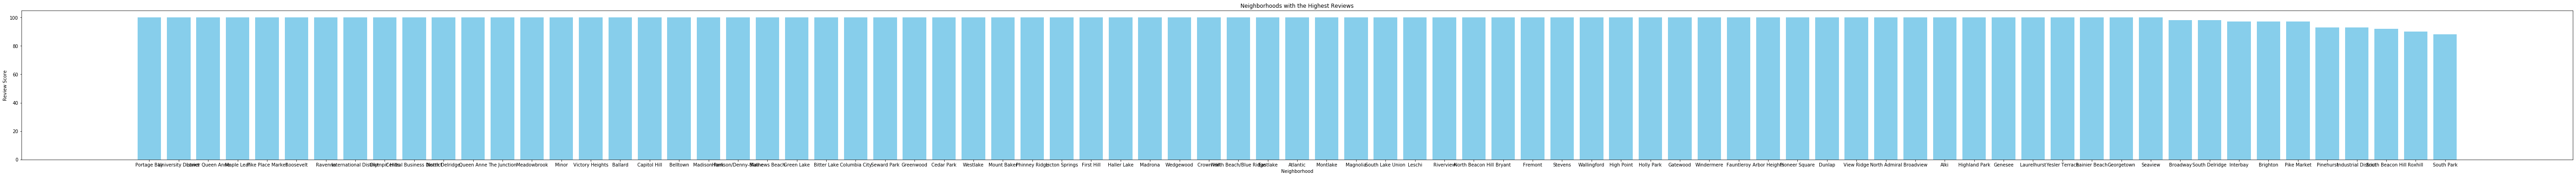

In [79]:
#lets see which neighbourhoods get the most average views. Can see we can remove neighbourhoods as it doesn't give any information
df_cleaned = Raw_Data_1.dropna(subset=['review_scores_rating', 'neighbourhood'])
df_sorted = df_cleaned.sort_values(by='review_scores_rating', ascending=False)
plt.figure(figsize=(100, 6))
plt.bar(df_sorted['neighbourhood'], df_sorted['review_scores_rating'], color='skyblue')
plt.xlabel('Neighborhood')
plt.ylabel('Review Score')
plt.title('Neighborhoods with the Highest Reviews')
plt.show()


In [80]:
average_ratings = Raw_Data_1.groupby('neighbourhood')['review_scores_rating'].mean().reset_index()
average_ratings

,neighbourhood,review_scores_rating
0,Alki,95.933333
1,Arbor Heights,98.000000
2,Atlantic,95.325581
3,Ballard,95.382514
4,Belltown,93.340659
...,...,...
76,Wallingford,94.168000
77,Wedgewood,94.000000
78,Westlake,96.500000
79,Windermere,97.500000


### Feature Engeenering

In [81]:
#which ameneties result in high reviews
Raw_Data_1.head()

columns = ['property_type','accommodates', 'bathrooms','bedrooms','beds','bed_type','amenities','avg_price','review_scores_rating']

In [82]:
raw_ameneties = Raw_Data_1[columns]
raw_ameneties.head()

,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,avg_price,review_scores_rating
0,Apartment,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.000000,95.0
1,Apartment,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",170.931271,96.0
2,House,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1301.818182,97.0
3,Apartment,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",100.000000,NaN
4,House,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",462.739726,92.0


In [83]:
#remove where Y is nan
raw_ameneties_1 = raw_ameneties.dropna(subset=['review_scores_rating'])
raw_ameneties_1.head()
raw_ameneties_1.shape

(3171, 9)

Because we have amenities as catagorical dat awe will have to do hot-encoding which will allow us to better analyse and model.

In [84]:
#hot encode property and bed_type
raw_ameneties_1['bed_type'].unique()

array(['Real Bed', 'Futon', 'Pull-out Sofa', 'Airbed', 'Couch'],
      dtype=object)

In [85]:
encoded_ameneties = pd.get_dummies(raw_ameneties_1, columns=['property_type', 'bed_type'], prefix=['property_type', 'bed_type'])

In [ ]:
encoded_ameneties.shape


In [86]:
#extract amenities and encode
amenities_dummies = encoded_ameneties['amenities'].str.extractall(r'"(.*?)"')[0].str.get_dummies().max(level=0)
amenities_dummies
#append amenities
amenities_dummies_final = pd.concat([encoded_ameneties, amenities_dummies], axis=1)
amenities_dummies_final

,accommodates,bathrooms,bedrooms,beds,amenities,avg_price,review_scores_rating,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,24-Hour Check-in,Air Conditioning,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Elevator in Building,Family/Kid Friendly,Fire Extinguisher,First Aid Kit,Free Parking on Premises,Hair Dryer,Hot Tub,Indoor Fireplace,Laptop Friendly Workspace,Lock on Bedroom Door,Other pet(s),Pets Allowed,Pets live on this property,Safety Card,Smoke Detector,Smoking Allowed,Suitable for Events,Washer / Dryer,Wheelchair Accessible,Wireless Internet
0,4,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.000000,95.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,4,1.0,1.0,1.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",170.931271,96.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,11,4.5,5.0,7.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1301.818182,97.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,6,2.0,3.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",462.739726,92.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5,2,1.0,1.0,1.0,"{""Wireless Internet"",""Free Parking on Premises...",125.629139,95.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3810,5,1.0,2.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",191.651982,92.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3811,3,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",67.782805,100.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3812,4,1.0,1.0,2.0,"{Internet,""Wireless Internet"",Kitchen,""Free Pa...",102.818815,96.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3813,6,2.0,3.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",359.000000,80.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [87]:
amenities_dummies_final = amenities_dummies_final.drop(columns = 'amenities')

### Analyze

the first Corralation heatmap was done after after removing columns that showed little to no correlation, the goal was to model the data however, the lack of relationships between the features proved that we really don't have a relationship with amenties and price or reviews.

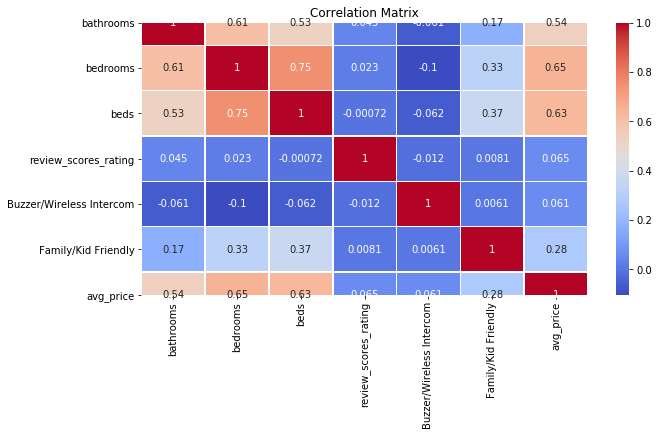

In [88]:
#reduced corr plot
amenities_dummies_final_1 = amenities_dummies_final[['bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'Buzzer/Wireless Intercom', 'Family/Kid Friendly', 'avg_price']]
 # Select only numeric columns for correlation matrix
numeric_columns = amenities_dummies_final_1.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(10,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()



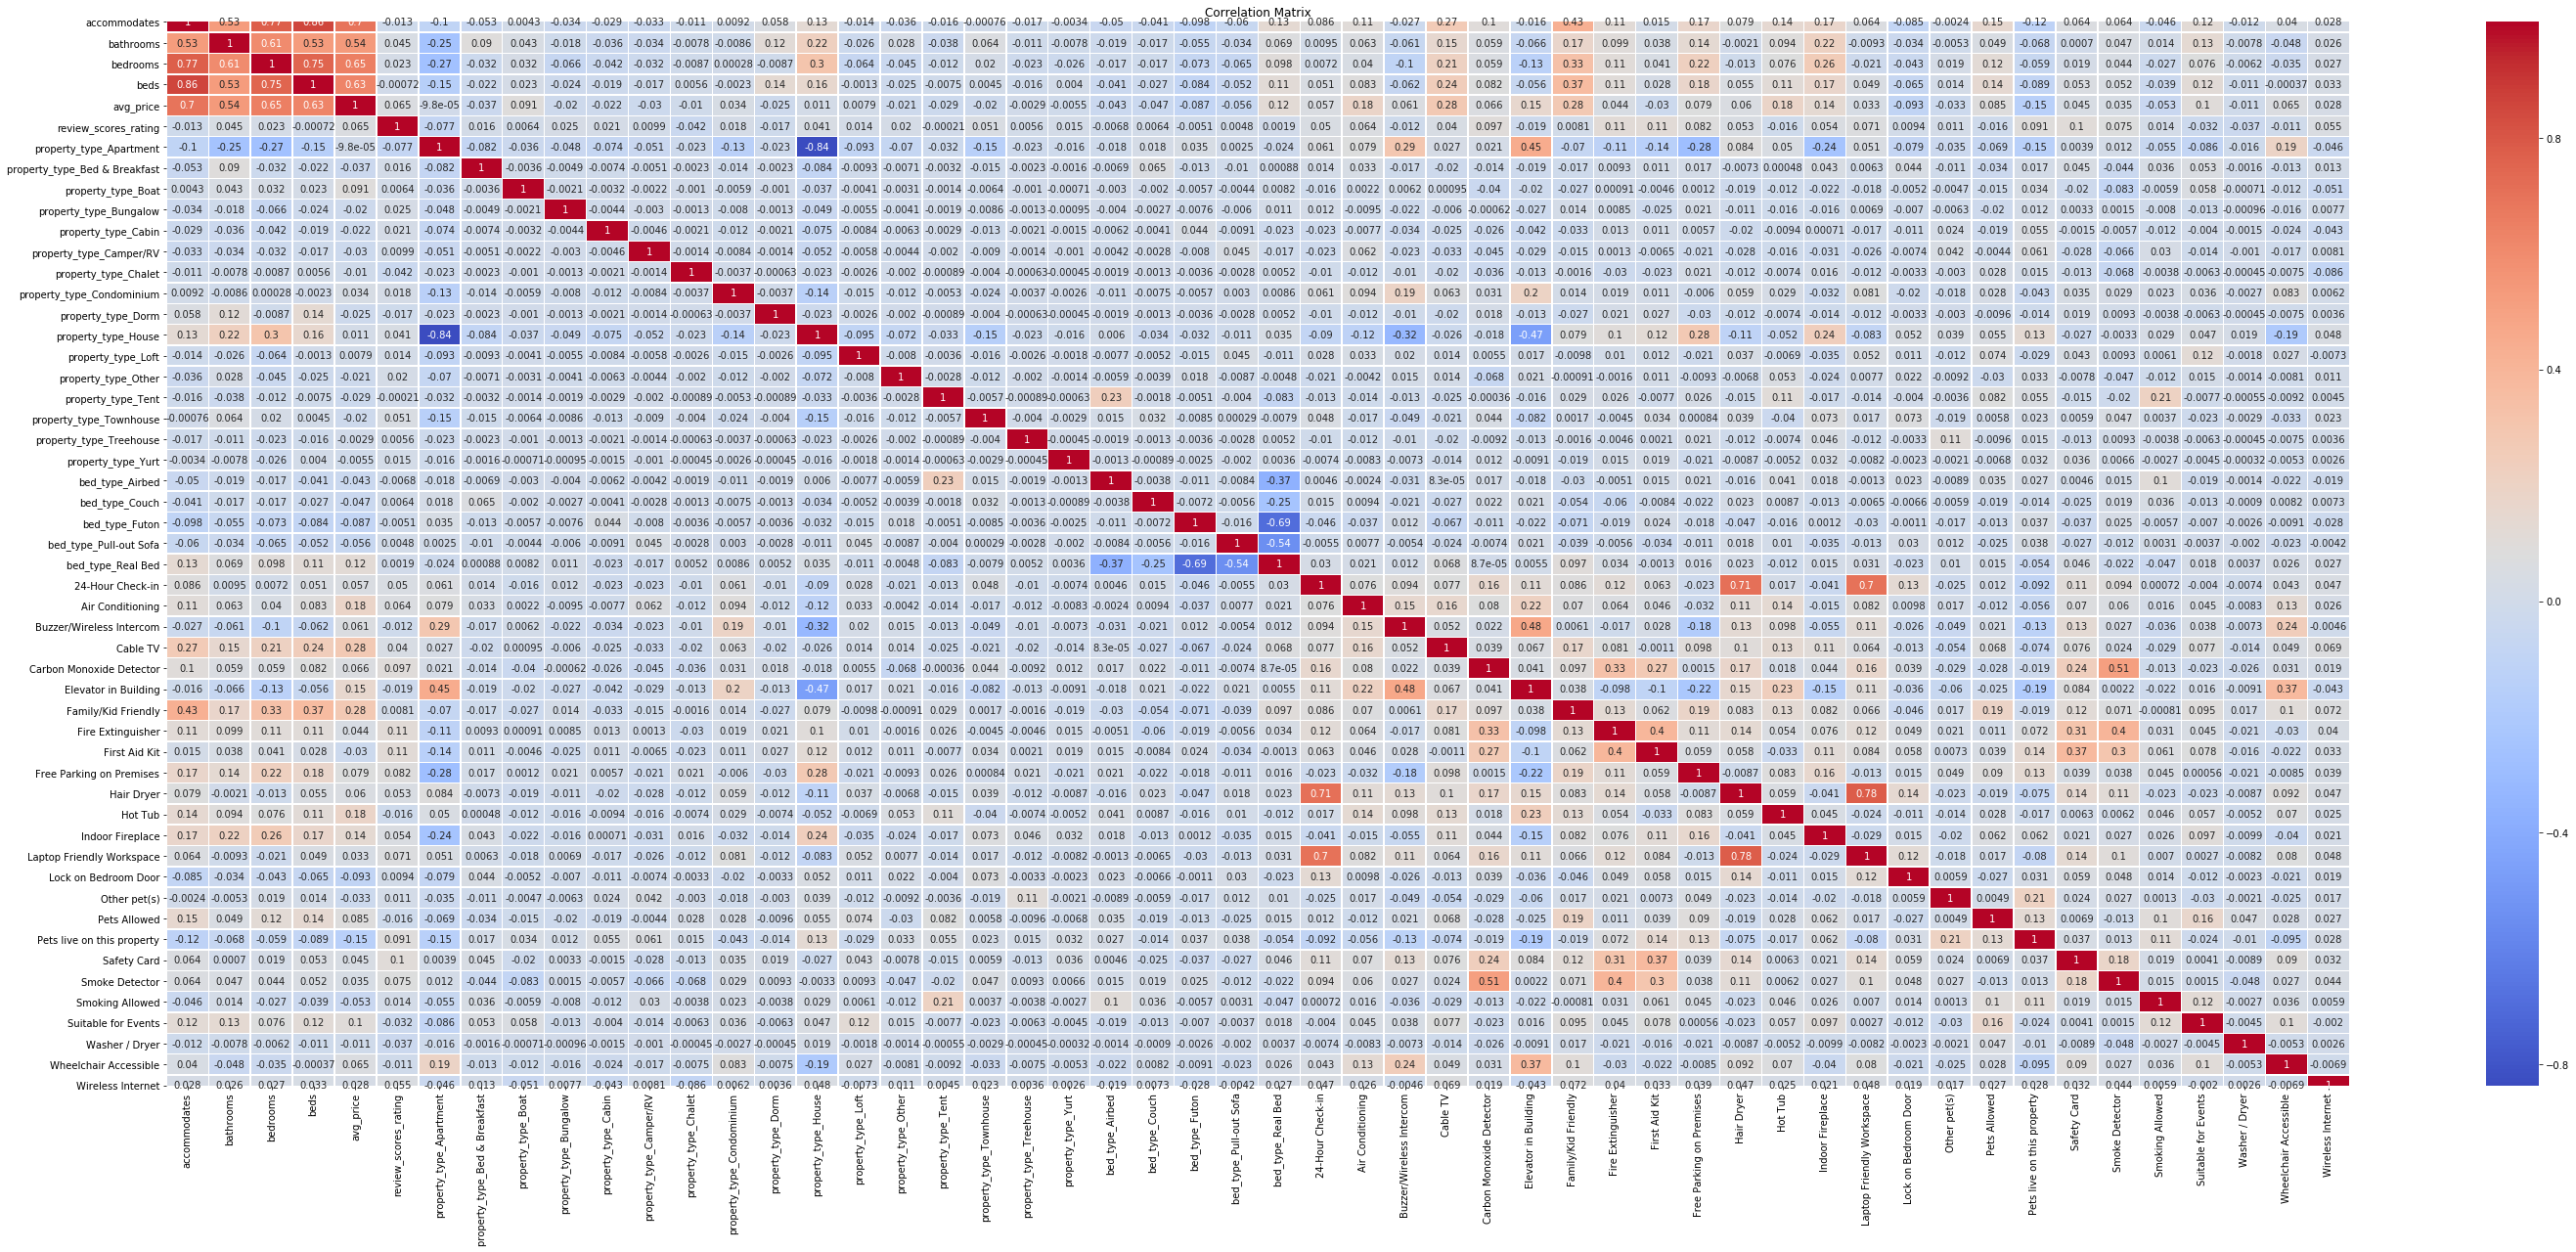

In [89]:
 # Select only numeric columns for correlation matrix
numeric_columns = amenities_dummies_final.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(50,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

#high correlation with accomodates and number of bedrooms, beds and bathrooms, 

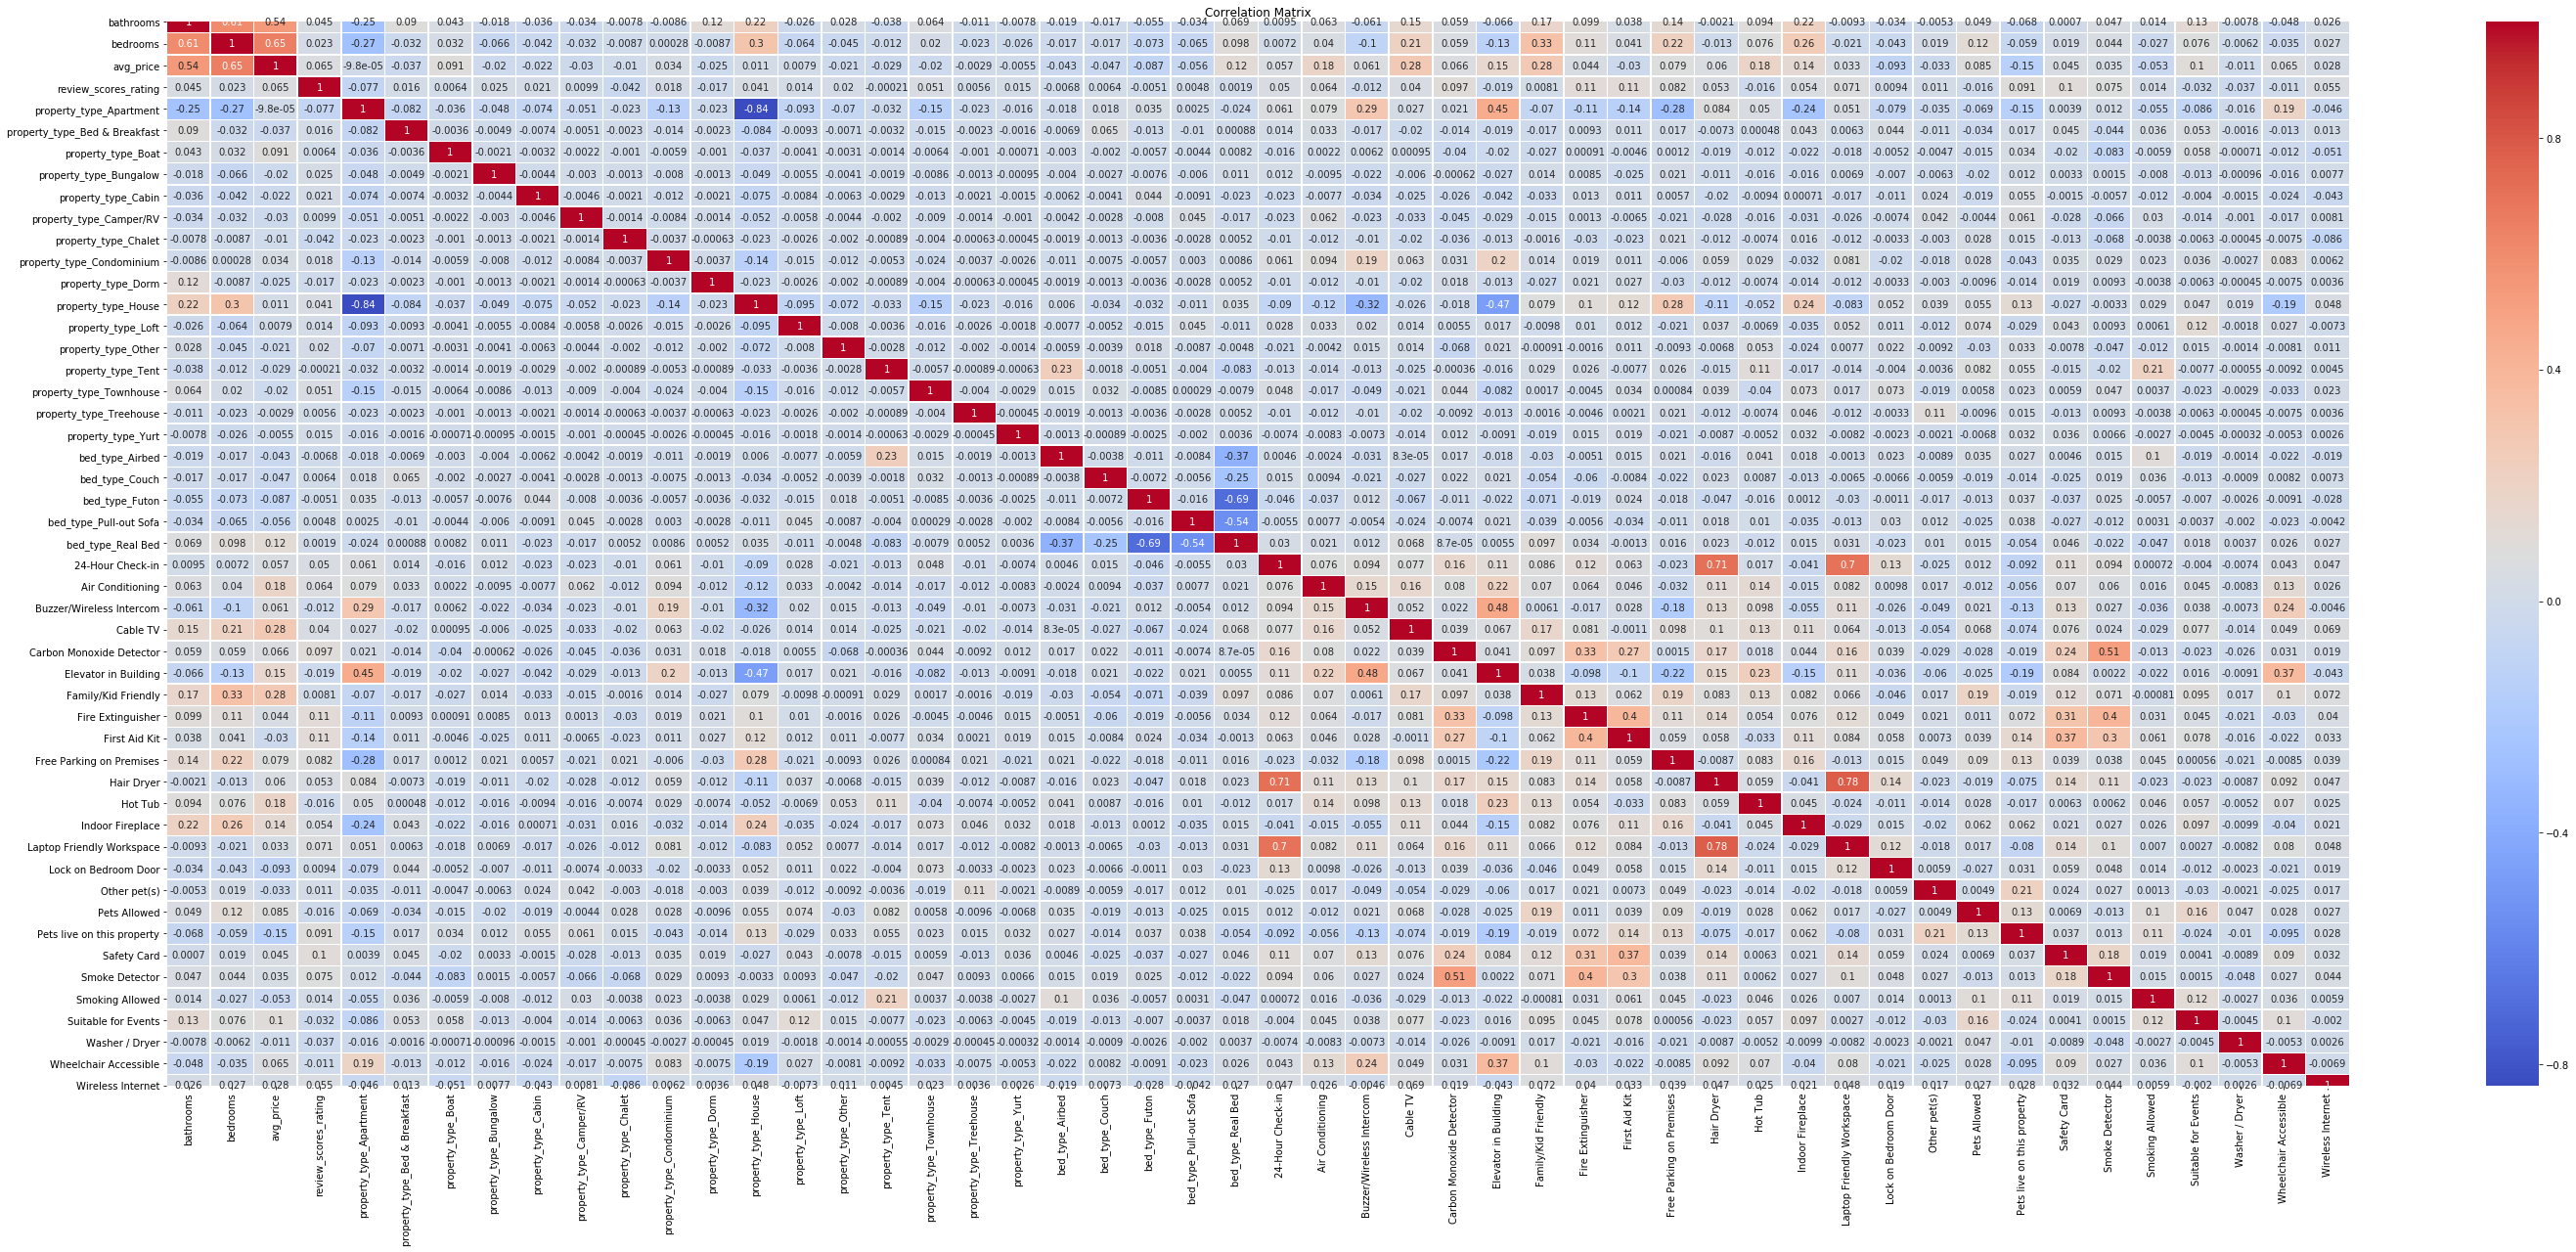

In [90]:
#drop accomodates and beds
amenities_dummies_final = amenities_dummies_final.drop(columns=['accommodates', 'beds'])
numeric_columns = amenities_dummies_final.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(50,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [91]:
#see other correlated variables and drop
upper = correlation_matrix.abs().where(np.triu(np.ones(correlation_matrix.abs().shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

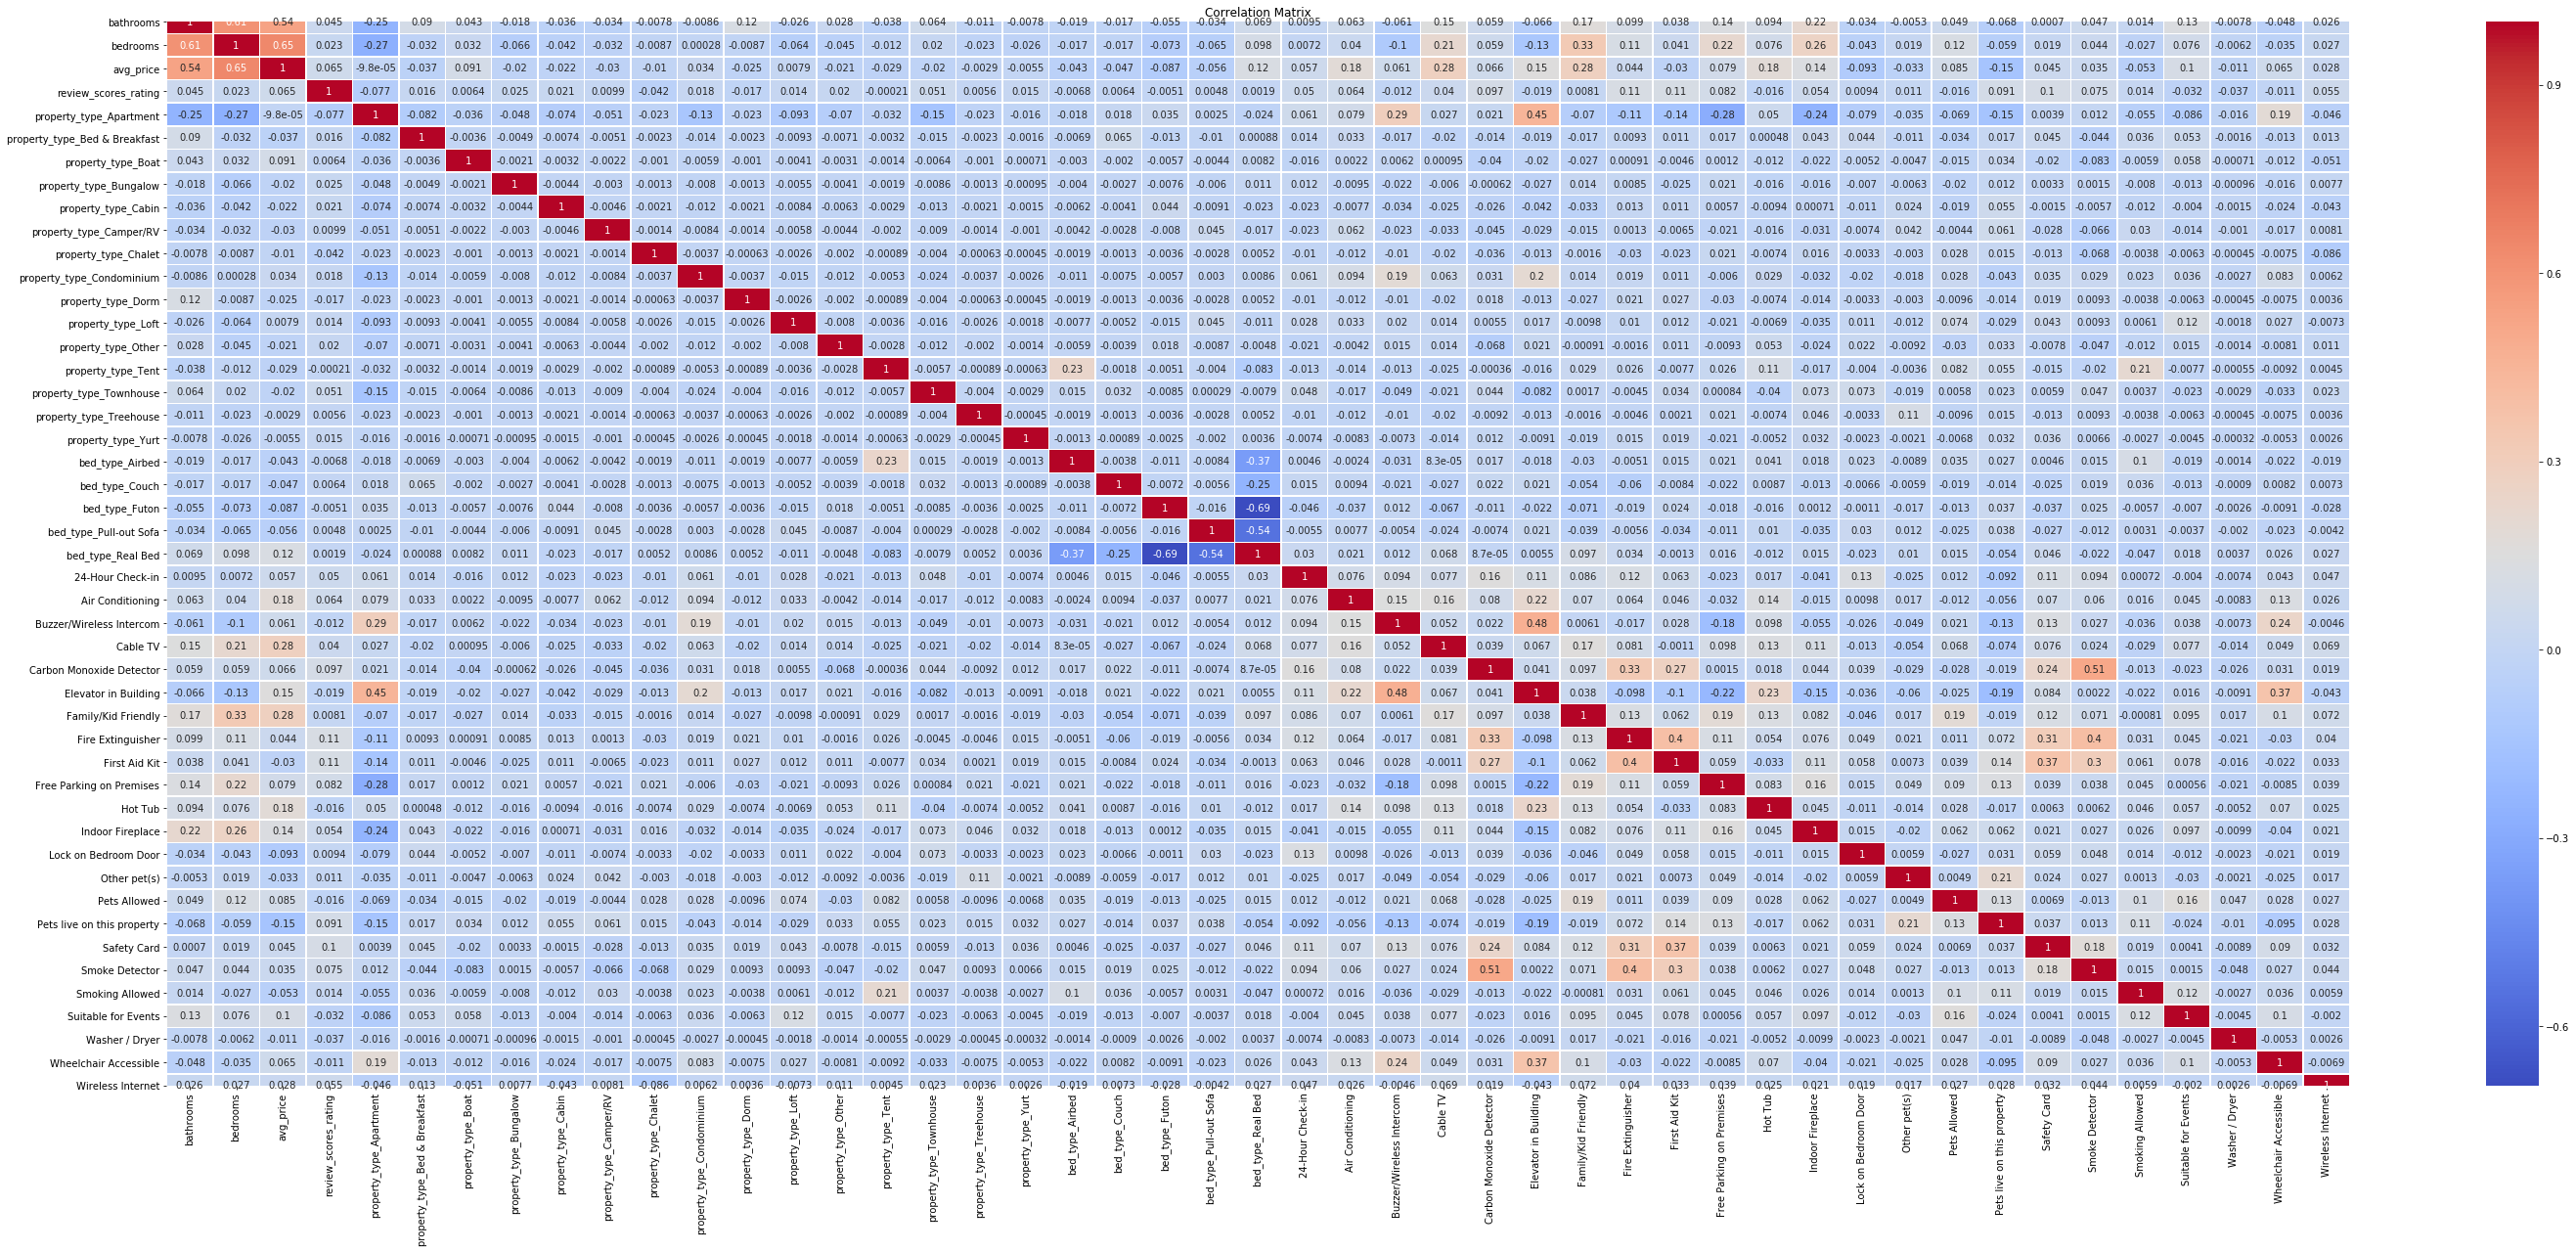

In [92]:
amenities_dummies_final.drop(to_drop, axis=1, inplace=True)
numeric_columns = amenities_dummies_final.select_dtypes(include='number')
# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(50,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

For a condensed summary of the analysis, this can be views on the post https://medium.com/@rethabilepule1997/uncovering-insights-on-seatle-airbnbs-14278c075702